# Spatio Temporal Fourier Analysis
### Vasha DuTell: vasha@berkeley.edu

This tutorial outlines calculating the Joint Spatiotemporal Power Spectrum from a movie sequence. The example is a natural movie, but you could use any movie-like signal.

Useful resources for for further reading include:
Dong & Attick 1995 - Statistics of Natural Time-Varying Images
[https://pdfs.semanticscholar.org/88f9/917840d378321417720ab203676997fe1de8.pdf](https://pdfs.semanticscholar.org/88f9/917840d378321417720ab203676997fe1de8.pdf)

Resources helpful to me in creating this include:  


## Dependencies

In [1]:
import numpy as np
import imageio
import scipy.ndimage
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gsp
import matplotlib.colors as colors

## Readin Data

We first readin our movie to be analyzed spatiotemporally

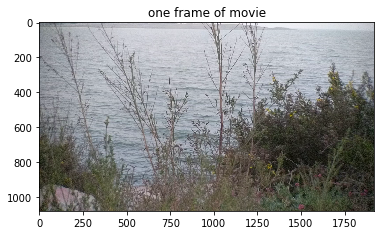

movie shape: (120, 1080, 1920, 3)


In [2]:
#path_to_movie = './data/ocean_clip_120fps.mp4'
path_to_movie = './data/flowers_120fps.mp4'
movie_fps = 120
#movie_cpd = x

n_frames = movie_fps

def readin_mp4_movie(path_to_movie, n_frames):
    movie = []
    reader = imageio.get_reader(path_to_movie,'ffmpeg')
    #movie = np.zeros((n_frames, reader[0].shape))
    for i, im in enumerate(reader):
            movie.append(im)
            if(i>=(n_frames-1)):
                break
    return(np.array(movie))

movie = readin_mp4_movie(path_to_movie, n_frames)
plt.imshow(movie[0])
plt.title('one frame of movie')
plt.show()
print(f'movie shape: {movie.shape}')

Now we have a 1-second movie clip. It's dimensions are:
120 frames
1080 pixels vertically
1920 pixels horizontally
3 color channels

Because we are interseted in the spatial-temporal power spectrum for all colors, we'll average over the color channels to put the image in greyscale.

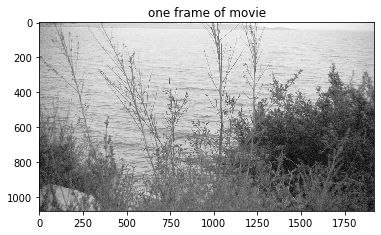

movie shape: (120, 1080, 1920)


In [3]:
movie = np.mean(movie,axis=-1)

plt.imshow(movie[0],cmap='Greys_r')
plt.title('one frame of movie')
plt.show()
print(f'movie shape: {movie.shape}')

Great! The movie shape now contains only one color channel: now we are ready to do Fourier analysis!

## Calculate Spatial Power Spectrum of one Frame

First, we'll look at space only and calculate the Power Spectrum of one frame.

To do this, we'll use a function called 'spatialft' that takes the fourier transform of a single image, and returns to us the power spectrum.

In [4]:
def spatialft(image, cosine_window=True, rmdc=True):
    """Take the fourier transform of an image (or flow field).
    shift the quadrants around so that low spatial frequencies are in
    the center of the 2D fourier transformed image"""

    #raised cosyne window on image to avoid border artifacts
    (dim1,dim2) = np.shape(image)
    if(cosine_window):
        cosfilter = np.tile(np.hanning(dim2), (dim1,1))*(np.tile(np.hanning(dim1), (dim2,1)).T)
        image = image * cosfilter
    
    # remove DC component
    if(rmdc):
        image =  image - np.mean(image)
    
    ps = np.abs(np.fft.fftshift(np.fft.fft2(image)))**2
    fqs = [np.fft.fftshift(np.fft.fftfreq(np.shape(image)[0])),
           np.fft.fftshift(np.fft.fftfreq(np.shape(image)[1]))]
    return(ps, fqs)

This function takes in an image, removes the DC component, optionally applied a cosine windowing function to the image, then calculates the spatial frequency spectrum using numpy's fft function.

The cosine windowing function is applied to the image before processing as a method to remove edge artifacts when the fourier transform is applied to the image. Mathematically, then the FFT is calculated, the image is treated as being bordered by zeros. This causes artificial edges at the borders of the image which give spurious spatial frequency content that is not truly there. The windowing function makes this falloff to zero gradual, removing those spurious edges.  

Here, we can see what the filter looks like and exactly is happening to the image when the filter is applied.

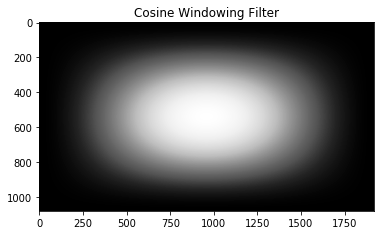

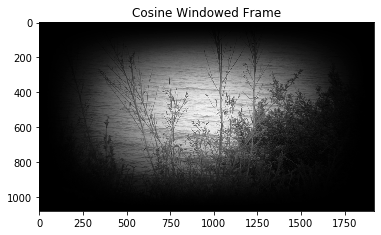

In [5]:
dim1, dim2 = np.shape(movie[0])
cosfilter = np.tile(np.hanning(dim2), (dim1,1))*(np.tile(np.hanning(dim1), (dim2,1)).T)
filtered_frame = movie[0] * cosfilter
plt.imshow(cosfilter,cmap='Greys_r')
plt.title('Cosine Windowing Filter')
plt.show()
plt.imshow(filtered_frame,cmap='Greys_r')
plt.title('Cosine Windowed Frame')
plt.show()

In [6]:
power_spectrum, frequency_spectrum = spatialft(movie[0])
print(f'Power Spectrum Shape: {np.shape(power_spectrum)}')
print(f'Frequency Spectrum Shape: {np.shape(frequency_spectrum[0])}, {np.shape(frequency_spectrum[1])}')

Power Spectrum Shape: (1080, 1920)
Frequency Spectrum Shape: (1080,), (1920,)


The Power spectrum of the image is the same shape as the image itself. The Power spectrum represents the power at each spatial frequency in x and y, where the frequencies range from DC to the nyquist frequency, 1 cycle per the length of the image.

The frequency spectrum is two vectors, each the length of the two image axes, and represents the spatial frequencies corresponding to the power spectrums axes.

## Visualizing the 2D Spatial Power Spectrum

We can visualize the power spectrum using a heatmap with contour lines. The main function to do this is 'contour_plotter'. This function plots the power spectrum in logspace as a greyscale heatmap. On top of this, it overlays contour lines that represent various percentages of the max power spectrum value. 'contour_plotter' calls a few helper functions to do these calculations.

In [7]:
def get_logspace_contours(raw_field, c_levels=None):
    """Get the contour locations by percentage of max power in logspace"""
    
    # settings for contour plots
    if not c_levels:
        c_levels = np.array([0.1, 0.3, 0.5, 0.7, 0.9]) # energy percentages to contour

    log_field = np.log10(raw_field)
    t_contours = c_levels * log_field.max()
    linear_t_contours = 10**t_contours
    
    return(c_levels, linear_t_contours)

def interp_get_contours(ps):
    interp_val = 5
    interp = scipy.ndimage.filters.gaussian_filter(ps, interp_val)
    clevels, contours = get_logspace_contours(interp)
    return(interp, contours, clevels)

def contour_plotter(ps, fqs, bar=True, ticks=True, title='Power Contour'):
    """Function to make contour plots"""
    
    c_cmap = 'brg' # colormap for contour plots
    interp, contours, clevels = interp_get_contours(ps)
    ratio = len(fqs[0])/len(fqs[1])
    
    plt.figure(figsize=(10, 10*ratio))
    cont_pl = plt.pcolormesh(fqs[1], fqs[0], interp,
                             cmap="gray",
                             norm=mpl.colors.LogNorm())#,extent=extents)
    if(bar):
        cont_pl = plt.colorbar()
    if not(ticks):
        plt.axis('off')
        
    pl = plt.contour(fqs[1], fqs[0], interp,
                     levels=contours,
                     cmap=c_cmap,
                     norm=mpl.colors.LogNorm())
    
    for i in range(len(clevels)):
        pl.collections[i].set_label(f'{clevels[i]*100:0.0f}%')
    plt.legend(loc='upper left')
    plt.gca().set_aspect(ratio)
    plt.title(title)
    return(pl)

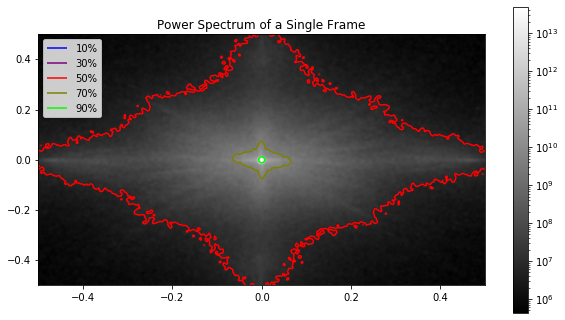

In [8]:
contour_plotter(power_spectrum, frequency_spectrum, title='Power Spectrum of a Single Frame')
plt.show()

There it is! The 2D spatial power spectrum of a single frame of our movie.  

Note that we're performed an 'fft shift', which means low spatial frequencies are represented in the middle of the frame. Because this is a natural image, the power is highest for these low frequencies, and power is lowest for low spatial frequencies represented on the edges of the image.  

This particular frame has a strong horizontal and vertical component - such biases are quite common, for example a strong horizon will cause in an elongated power along the vertical in the power spectrum plot.  Repeated ertical objects tend to cause elongated the horizontal power.  

This tendency for power to be strongest in low spatial frequencies, and to falloff as spatial frequency increases is known as the 'power law', or '1/f relationship'. The power law is best visualized by averaging over all orientations in the image, reducing this to a 1-D plot. That's what we'll do next!  

In [9]:
def azimuthalAverage(image, nyquist, center=None, bin_in_log=False):
    """      
    Calculate the azimuthally averaged radial profile. (Intended for 2d Power Spectra)
    image - The 2D image (2d power spectrum)
    nyquist - max frequency value (assume same for x and y)
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)
    num_bins = np.min(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    #ASSUME HERE THAT MAX FREQUENCY IS EQUAL ON BOTH AXES & GRANULARITY VARIES ***
    normalized = ((x-center[0])/np.max(x),(y-center[1])/np.max(y))
    r = np.hypot(normalized[0], normalized[1])
    #don't calculate corners
    keep_circle = np.where(r<=np.max(y))
    r = r[keep_circle]
    image = image[keep_circle]

    # number of bins should be equivalent to the number of bins along the shortest axis of the image.
    if(bin_in_log):
        bin_edges = np.histogram_bin_edges(np.log(r), num_bins)
        bin_edges = np.exp(bin_edges)
    else:
        bin_edges = np.histogram_bin_edges(r,num_bins)
    
    r_binned = np.digitize(r, bin_edges)
    binmean = np.zeros(num_bins)
    for i in range(num_bins):
        binmean[i] = np.mean(image[np.where(r_binned==i+1)])
    bin_centers = bin_edges[:-1] + ((bin_edges[1]-bin_edges[0])/2)
    bin_centers = bin_centers/np.max(bin_centers)*nyquist

    return(binmean, bin_centers)

the 'azimuthalAverage' function takes any 2d array - in this case our 2d power spectrum, and takes the circular average of the array, resulting in a 1d function that represents the mean at each radial distance. Think of the hand of a clock spinning around the middle and taking the average of all the values it touches as it makes a full circle. Our result is a set of powers for a set of radii - in our case the radii represent spatial frequencies.  

In [10]:
power_spec_1d, freqs_1d = azimuthalAverage(power_spectrum, max(frequency_spectrum[0]))
print(f'1D Power Spectrum Shape: {np.shape(power_spec_1d)}')
print(f'1D Frequency Spectrum Shape: {np.shape(freqs_1d)}')

1D Power Spectrum Shape: (1080,)
1D Frequency Spectrum Shape: (1080,)


Now we have 1080 values for 1080 spatial frequencies. Note that we threw away the finer sampling we had in the larger dimension. We can't sample that as well. A different implementation could retain these values.  

We'll also want to visuzlize the power spectrum, but this time in 1d as a line plot.

In [11]:
def plot_1d_ps(ps1d, fqs, title='1D Power Spectrum'):
    '''
    Plot a 1d power spectrum, and compare to multiple alpha slopes.
    '''
    plt.figure(figsize=(10,7))
    plt.loglog(fqs, ps1d, '.')

    onef = 1/(fqs) * np.min(ps1d)
    onef2 = 1/(fqs)**2 * np.min(ps1d)
    onef3 = 1/(fqs)**3 * np.min(ps1d)
    onef4 = 1/(fqs)**4 * np.min(ps1d)
    onef5 = 1/(fqs)**5 * np.min(ps1d)

    plt.loglog(fqs, onef, label='1/f')
    plt.loglog(fqs, onef2, label='1/f^2')
    plt.loglog(fqs, onef3, label='1/f^3')
    plt.loglog(fqs, onef4, label='1/f^4')
    plt.loglog(fqs, onef5, label='1/f^5')

    plt.xlabel('Cycles per Pixel')
    plt.ylabel('Power')
    plt.legend()
    plt.title(title)
    

'plot_1d_ps' takes a power spectrum and a set of frequencies and plots them against each other. In addition, it plots a corresponding set of lines representing the slope of the falloff for different powers of f (values of alpha).

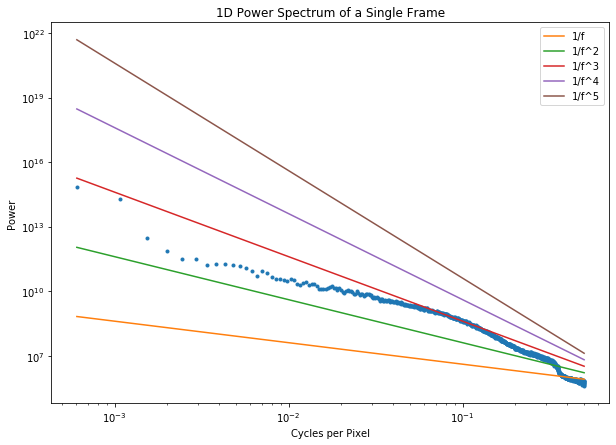

In [12]:
plot_1d_ps(power_spec_1d, freqs_1d, title='1D Power Spectrum of a Single Frame')

For a single frame, it is not surprising to see deviation from 1/f^2. Averaged over many frames of many different types of movies, one would see the line falling closely along 1/f^2.

## Calculate Spatiotemporal Power Spectrum of the Movie

Now that we understand what is going on in the strictly spatial Fourier analysis, let's extend into the time domain!  

We'll put the cosine window cacluation into its own function since the 3rd dimension makes things a little more complex. This function applies the same filter to the frames that we saw ealier, but now, we'll apply the same filter temporally. In frame space this corresponds to the entirety of early and end frames bing set to zero, and middle frames being retained - but still with the spatial window we visualized earlier.  

In [13]:
def cos_filter_3d(movie):
    #filter first with cosine window
    (dimt,dim1,dim2) = np.shape(movie)
    dt = np.tile(np.hanning(dimt),(dim1,dim2,1)).transpose(2,0,1)
    d1 = np.tile(np.hanning(dim1),(dimt,dim2,1)).transpose(0,2,1)
    d2 = np.tile(np.hanning(dim2),(dimt,dim1,1))

    cosfilter = dt*d1*d2
    movie = np.array(cosfilter * movie)
    return(movie)


def st_ps(movie, cosine_window=True):
    '''
    Calculate the spatiotemporal power spectrum of a movie.
    
    Parameters
    ----------
    movie:      list of 3d numpy arrays definig movie for 3d fourier transform analysis.
    ##fps:        frames per second of movie capture
    ##ppd:        pixels per degree of frames
    
    Returns:
    --------
    ps:         power specturm of movie
    fq1d:       spatial frequency spectrum (dimensions of 0 axis of ps)
    ft1d:       temporal frequency specturm (dimensions of 1 axis of ps)
    
    '''
        
    #raised cosyne window on image to avoid border artifacts
    (dimf, dim1, dim2) = np.shape(movie)
    if(cosine_window):
        movie = cos_filter_3d(movie)
    
    #subtract DC component
    movie = movie - np.mean(movie)    
    
    #3d ft 
    ft_3d = np.abs(np.fft.fftn(movie))**2
    fqs_3d = [np.fft.fftshift(np.fft.fftfreq(np.shape(movie)[0])),
           np.fft.fftshift(np.fft.fftfreq(np.shape(movie)[1])),
           np.fft.fftshift(np.fft.fftfreq(np.shape(movie)[2]))]
    
    #azimuthal avearge in spatial dimension
    ft_2d = []
    for f in range(np.shape(ft_3d)[0]):
        ps, fqs_2d = azimuthalAverage(ft_3d[f], max(fqs_3d[0]))
        ft_2d.append(ps)
    fqs_2d_space = np.fft.fftfreq(np.shape(ft3d)[1]
    fqs_2d = [fqs_3d[0], fqs_2d]
        
    return(ft_3d, ft_2d, fqs_3d, fqs_2d)
    

*** Note *** This takes a few minutes to run for a 1080x1920x120 movie!

In [14]:
ps_3d, ps_2d, fqs_3d, fqs_2d = st_ps(movie, cosine_window=True)

In [15]:
print(f'3D Power Spectrum Shape: {np.shape(ps_3d)}')
print(f'2D Power Spectrum Shape: {np.shape(ps_2d)}')
print(f'3D Frequeencies Shape: {np.shape(fqs_3d[0])}, {np.shape(fqs_3d[1])}, {np.shape(fqs_3d[2])}')
print(f'2D Frequeencies Shape: {np.shape(fqs_2d[0])}, {np.shape(fqs_2d[1])}')


3D Power Spectrum Shape: (120, 1080, 1920)
2D Power Spectrum Shape: (120, 1080)
3D Frequeencies Shape: (120,), (1080,), (1920,)
2D Frequeencies Shape: (120,), (1080,)


## Visualize the 2D spectrum

We've calculated the 3d power spectrum of the movie, then averaged radially along the spatial dimension to get a 2D power spectrum - space and time.  

Since the 3D power spectrum is a 3D tensor, it would be difficult to visualize this full spectrum in one plot - though one could sample slies from it. Such an analysis would be interesting to analyze the directionality of spatial frequencies and their interaction with temporal frequencies. Here, instead of trying to do this, we will focus on visualizing our radially averaged 2d plot.

To visualize this well we'll create a large plot that is a combination of many plots. The first will be a 2d heatmap, with spatial and temporal frequencies as the axes, which shows where in this 2D spectrum power is localized, and where it is low.  The second plot will sample slices at given temporal frequencies from this heatmap, showing these slices as 1d lines plotting power along the spatial frequency spectrum. The third plot will be the opposite of this, sampling slices at given spatial frequencies from the heatmap, showing slices as 1d lines plotting power against the temporal frequency.   

Lets see what is looks like!

In [45]:
def da_plot_power(power_spectrum, fqspace, fqtime, nsamples = 7, minmaxcolors=(None, None), logscale=True, figname='Power Spectrum'):
    '''
    THE Dong & Attick Plot (Dong & Attick 1995; fig 7) with heatmap added.
    Produces three plots:
        - Heatmap displying the joint spatial/temporal amplitude
        - Samples from this plot along spatial and temporal lines:
            * plots of spatial power spectrum along given temporal values
            * plots of temporal spectrum along given spatial values

    Parameters
    ----------
        power_spectrum:   2d numpy array of spatio/temporal power
        fqspace:    1d numpy array of spatial frequency vals for spectrum
        fqtime:   1d numpy array of temporal frequency vals for spectrum
        nsamples: integer number of lines to plot for sampling plots
        power (bool):   Are we calculating the power spectrum (default) or amplitude
        psd (bool):     Normalize to power spectral density (default), or raw power?
        figname (str):  String prefix to name of figure to be saved
    
    Returns:
    --------
        mftchunk
        azmchunk
        freqspace1d
        freqspacefull
        freqtime

    '''

    #calculate sampling positions
    #space
    space_end_offset = 1
    space_end_sample = len(fqspace)-space_end_offset #sample everything for now
    #time
    time_end_offset = 1
    time_end_sample = len(fqtime)-time_end_offset #sample everything for now
    #joint
    n_datpoints = len(fqspace)*len(fqtime)
    
    #colors for lines: generate by indexes in log coordinates.
    spacesamplefqs_idx = np.round(np.geomspace(space_end_offset, space_end_sample,
                                      nsamples),0).astype(int)
    timesamplefqs_idx = np.round(np.geomspace(time_end_offset, time_end_sample,
                                     nsamples),0).astype(int)

    spacecolors = np.array(['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet'])
    timecolors = spacecolors

    #make a grid
    fig = plt.figure(figsize=(10,6))
    full_grid = gsp.GridSpec(2,3)
    
    #layout of subplots
    grid_hm = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[0:2,0:2])
    grid_time = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[1,2])
    grid_space = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[0,2])
    
    #heatmap
    axes_hm = plt.subplot(grid_hm[0])
    
    # plot the correct spectrum (power/amplitude/psd)
    plot_spectrum = power_spectrum
    #convert to db
   # plot_spectrum /= np.max(plot_spectrum) #normalize so max val is zero (DB scaling)
    plot_spectrum = np.log10(plot_spectrum)
    
    if(minmaxcolors[0]):
        minc = np.log10(np.abs(minmaxcolors[0]))
        maxc = np.log10(np.abs(minmaxcolors[1]))
        #minc = minmaxcolors[0]
        #maxc = minmaxcolors[1]
    else:
        minc = np.log10(np.abs(np.min(plot_spectrum)))
        maxc = np.log10(np.abs(np.max(plot_spectrum)))
    clev = np.linspace(minc,maxc,5)
    print(fqtime.shape, fqspace.shape, plot_spectrum.shape)
    hm = axes_hm.contourf(fqtime, fqspace, plot_spectrum.T,
                          clev,
                          cmap='gray',
                          norm=mpl.colors.Normalize(minc, maxc))
    
    #hm = axes_hm.pcolormesh(fqtime, fqspace, plot_spectrum,
    #                     cmap='gist_gray',
    #                       norm=mpl.colors.LogNorm(minc, maxc))
    
    if(logscale):
        axes_hm.set_xscale("log") 
        axes_hm.set_yscale("log")
    axes_hm.set_xlabel('Hz')
    axes_hm.set_ylabel('cycles/deg')
    axes_hm.set_title(f'{figname} Log Power') 
    plt.colorbar(hm)

    #add lines
    for s in range(nsamples):
        #lines in time
        axes_hm.axvline(fqtime[timesamplefqs_idx[s]],c=timecolors[s],ls='-')
        #lines in space
        axes_hm.axhline(fqspace[spacesamplefqs_idx[s]],c=spacecolors[s],ls='--')

    #spaceplot
    axes_space = plt.subplot(grid_space[0])
    for i, tf_idx in enumerate(timesamplefqs_idx):
        axes_space.semilogx(fqspace, plot_spectrum[tf_idx,:],
                        label='{0:0.1f} Hz'.format(fqtime[tf_idx]),
                        c=timecolors[i])
    
    #axes_space.plot(fqspace[1:],1e-80/(fqspace[1:]),c='black') # 1/f line
    #axes_space.plot(fqspace[1:],1e-80/(fqspace[1:]**2),c='black') # 1/f^2 line
    
    axes_space.set_title('Spatial Frequency')
    axes_space.set_xlabel('cpd')
    axes_space.set_ylabel(f'Log Power')
    axes_space.set_xlim(fqspace[1],fqspace[-1])
    axes_space.set_ylim(bottom=minc) #, top=maxc)
    axes_space.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))
    axes_space.legend(fontsize=8)

    #timeplot
    axes_time = plt.subplot(grid_time[0])
    for i, sf_idx in enumerate(spacesamplefqs_idx):
        axes_time.semilogx(fqtime, plot_spectrum[:,sf_idx],
                       label='{0:0.1f} cpd'.format(fqspace[sf_idx]),
                       c=spacecolors[i])
    #axes_time.plot(fqtime[1:],1e4/(fqtime[1:]),c='black') # 1/f line
    #axes_time.plot(fqtime[1:],1e7/(fqtime[1:]**2),c='black') # 1/f^2 line
    axes_time.set_title('Temporal Frequency')
    axes_time.set_xlabel('Hz')
    axes_time.set_ylabel(f'Log Power') 
    axes_time.set_xlim(fqtime[1],fqtime[-1])
    axes_time.set_ylim(bottom=minc) #, top= maxc)
    axes_time.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))
    axes_time.legend(fontsize=8)

    plt.tight_layout()

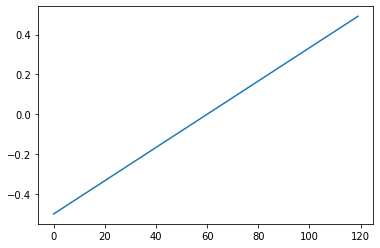

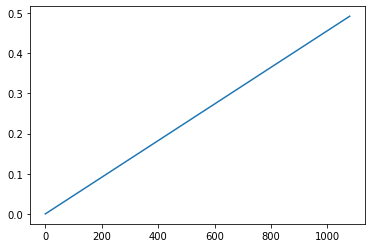

In [51]:
plt.plot(fqs_2d[0])
plt.show()
plt.plot(fqs_2d[1])
plt.show()

(120,) (1080,) (120, 1080)


/home/vasha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:130: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


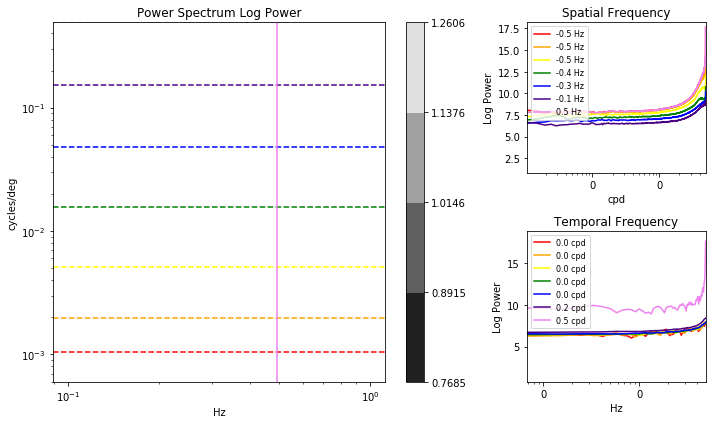

In [47]:
da_plot_power(ps_2d, fqs_2d[1], fqs_2d[0], nsamples = 7)